Repo root + output folder

In [2]:
import os
from pathlib import Path

HERE = Path.cwd()
if HERE.name == "notebooks":
    os.chdir(HERE.parent)

print("CWD:", Path.cwd())

OUT_DIR = Path("outputs/figures/02_splits")
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Saving to:", OUT_DIR.resolve())


CWD: /Users/samyuktareddy/Desktop/MOF Gas absorption
Saving to: /Users/samyuktareddy/Desktop/MOF Gas absorption/outputs/figures/02_splits


Load splits and the labelled datasets

In [3]:
import json
import pandas as pd
from pathlib import Path

SPLITS_PATH = Path("data/processed/splits_seed42.json")
LABELED_PATH = Path("data/processed/MOFCSD_with_co2_labels.csv")

if not SPLITS_PATH.exists():
    raise FileNotFoundError(f"Missing {SPLITS_PATH}. Run make_splits.py first.")
if not LABELED_PATH.exists():
    raise FileNotFoundError(f"Missing {LABELED_PATH}. Run merge_labels_into_mofcsd.py first.")

splits = json.loads(SPLITS_PATH.read_text())
df = pd.read_csv(LABELED_PATH)

id_col = "refcode"
y_col = "co2_uptake"

df[id_col] = df[id_col].astype(str).str.upper().str.strip()

# keep only labeled rows
df_lab = df[df[y_col].notna()].copy()
df_lab[y_col] = df_lab[y_col].astype(float)

train_ids = set(x.upper() for x in splits["train"])
val_ids   = set(x.upper() for x in splits["val"])
test_ids  = set(x.upper() for x in splits["test"])

print("Labeled rows:", len(df_lab))
print("Split sizes:", len(train_ids), len(val_ids), len(test_ids))

Labeled rows: 363
Split sizes: 254 54 55


Sanity checks

In [4]:
# 1) No overlap between splits
assert train_ids.isdisjoint(val_ids)
assert train_ids.isdisjoint(test_ids)
assert val_ids.isdisjoint(test_ids)

# 2) Splits cover all labeled IDs (as you intended)
all_split = train_ids | val_ids | test_ids
print("Total unique IDs in splits:", len(all_split))
print("Total labeled IDs in df:", df_lab[id_col].nunique())

# If these differ, it's usually because some labels were filtered/changed later
missing = set(df_lab[id_col].unique()) - all_split
extra = all_split - set(df_lab[id_col].unique())

print("Labeled IDs missing from split file:", len(missing))
print("IDs in split file but not labeled df:", len(extra))

Total unique IDs in splits: 363
Total labeled IDs in df: 363
Labeled IDs missing from split file: 0
IDs in split file but not labeled df: 0


Create split dataframes

In [5]:
df_train = df_lab[df_lab[id_col].isin(train_ids)].copy()
df_val   = df_lab[df_lab[id_col].isin(val_ids)].copy()
df_test  = df_lab[df_lab[id_col].isin(test_ids)].copy()

len(df_train), len(df_val), len(df_test)

(254, 54, 55)

Figure 1: Split sizes bar chart

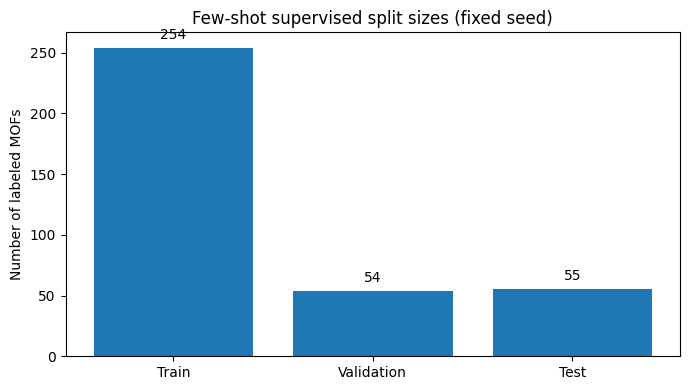

Saved: outputs/figures/02_splits/split_sizes_v1.png


In [6]:
import matplotlib.pyplot as plt

sizes = [len(df_train), len(df_val), len(df_test)]
names = ["Train", "Validation", "Test"]

plt.figure(figsize=(7,4))
plt.bar(names, sizes)
plt.ylabel("Number of labeled MOFs")
plt.title("Few-shot supervised split sizes (fixed seed)")

for i, v in enumerate(sizes):
    plt.text(i, v + max(sizes)*0.02, str(v), ha="center", va="bottom", fontsize=10)

out = OUT_DIR / "split_sizes_v1.png"
plt.tight_layout()
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

FIGURE 2: CO₂ uptake distribution by split 

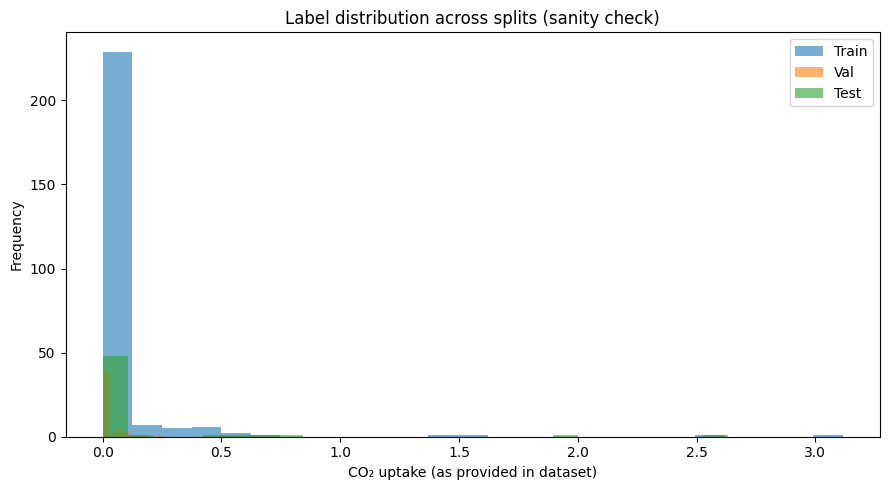

Saved: outputs/figures/02_splits/uptake_by_split_hist_v1.png


In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.hist(df_train[y_col], bins=25, alpha=0.6, label="Train")
plt.hist(df_val[y_col],   bins=25, alpha=0.6, label="Val")
plt.hist(df_test[y_col],  bins=25, alpha=0.6, label="Test")

plt.xlabel("CO₂ uptake (as provided in dataset)")
plt.ylabel("Frequency")
plt.title("Label distribution across splits (sanity check)")
plt.legend()

out = OUT_DIR / "uptake_by_split_hist_v1.png"
plt.tight_layout()
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

FIGURE 3: Violin plot by split

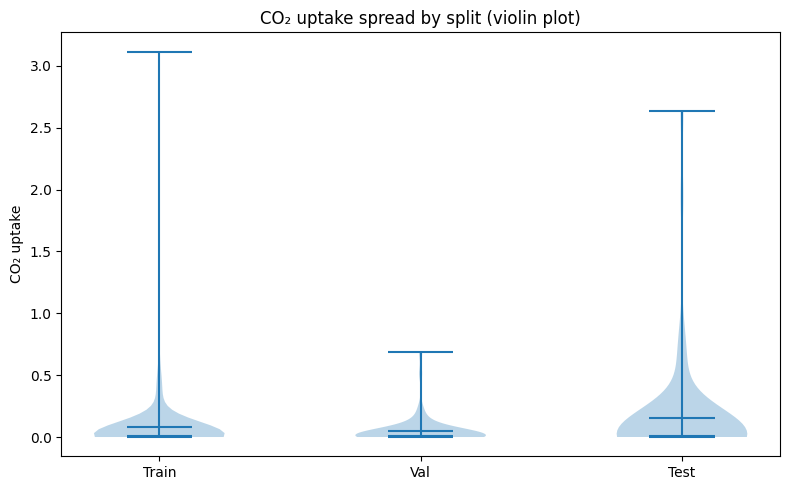

Saved: outputs/figures/02_splits/uptake_by_split_violin_v1.png


In [8]:
import matplotlib.pyplot as plt

data = [df_train[y_col].values, df_val[y_col].values, df_test[y_col].values]

plt.figure(figsize=(8,5))
plt.violinplot(data, showmeans=True, showmedians=True)
plt.xticks([1,2,3], ["Train", "Val", "Test"])
plt.ylabel("CO₂ uptake")
plt.title("CO₂ uptake spread by split (violin plot)")

out = OUT_DIR / "uptake_by_split_violin_v1.png"
plt.tight_layout()
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

Few-shot regimes (k-shot) preview table

In [9]:
# Example few-shot regimes you can report later
k_values = [5, 10, 20, 50, 100, 150, len(df_train)]
rows = []
for k in k_values:
    rows.append({
        "k_shot_train": min(k, len(df_train)),
        "val_size": len(df_val),
        "test_size": len(df_test)
    })
pd.DataFrame(rows)

,k_shot_train,val_size,test_size
0,5,54,55
1,10,54,55
2,20,54,55
3,50,54,55
4,100,54,55
5,150,54,55
6,254,54,55


A fixed split (reproducibility)

Legitimately few-shot (train size small relative to MOF universe)

Distributions across splits are not wildly inconsistent (sanity)